In [1]:
import os
import tempfile
import time
import numpy as np
import faiss
import h5py
import requests
from collections import defaultdict
import bisect
import matplotlib.pyplot as plt

In [2]:
# --- Data Utilities ---

def download_fashion_mnist(cache_path, url):
    if not os.path.exists(cache_path):
        print("Downloading Fashion-MNIST (~300 MB)…")
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            with open(cache_path, "wb") as f:
                f.write(response.content)
        else:
            raise Exception(f"Failed to download dataset: HTTP{response.status_code}")

def load_fashion_mnist(cache_path):
    with h5py.File(cache_path, "r") as f:
        xb = f["train"][:].astype(np.float32)
        xq = f["test"][:].astype(np.float32)
        gt = f["neighbors"][:]
    return xb, xq, gt

In [ ]:
# --- Indexing Utilities ---

def build_kmeans(xb, d, n_clusters, niter=20):
    train_sample = xb[np.random.choice(len(xb), size=min(50000, len(xb)), replace=False)]
    kmeans = faiss.Kmeans(d, n_clusters, niter=niter, verbose=True, spherical=False)
    kmeans.train(train_sample)
    return kmeans

def assign_vectors_to_clusters(xb, kmeans, n_assign):
    _, assignments = kmeans.index.search(xb, n_assign)
    return assignments

def cross_pollinate_metadata(xb, xb_inner_assignments, inner_centroids, inner_to_outer, N_CROSS):
    vector_metadata = defaultdict(dict)
    for idx, inner_ids in enumerate(xb_inner_assignments):
        for inner_id in inner_ids[:N_CROSS]:
            outer_id = inner_to_outer[inner_id][0]
            centroid = inner_centroids[inner_id]
            vec = xb[idx]
            dist = np.linalg.norm(vec - centroid)
            cos_sim = np.dot(vec, centroid) / (np.linalg.norm(vec) * np.linalg.norm(centroid) + 1e-8)
            vector_metadata[outer_id].setdefault(inner_id, []).append((dist, cos_sim, idx))
    # Sort each list by Euclidean distance to centroid
    for outer_id in vector_metadata:
        for inner_id in vector_metadata[outer_id]:
            vector_metadata[outer_id][inner_id].sort()
    return vector_metadata

def build_outer_to_num_inner_clusters(vector_metadata):
    """
    Build a dictionary mapping each outer cluster id to the number of inner clusters it contains.
    Args:
        vector_metadata: dict[outer_id][inner_id] -> list of vectors
    Returns:
        outer_to_num_inner_clusters: dict[outer_id] -> int (number of inner clusters)
    """
    outer_to_num_inner_clusters = {}
    for outer_id in vector_metadata:
        outer_to_num_inner_clusters[outer_id] = len(vector_metadata[outer_id])
    return o

In [9]:
# --- Search Utilities ---
def pad_to_k(arr, k, pad_value):
    arr = list(arr)
    if len(arr) < k:
        arr += [pad_value] * (k - len(arr))
    return arr[:k]

def search_query_cross_pollination(
    x, outer_ids, inner_kmeans, vector_metadata, xb, k, d, N_PROBE=1
):
    best_heap = []
    tau = float("inf")
    for outer_id in outer_ids:
        if outer_id not in vector_metadata:
            continue
        inner_ids = list(vector_metadata[outer_id].keys())
        if not inner_ids:
            continue
        inner_centroids_subset = inner_kmeans.centroids[inner_ids]
        index_l2 = faiss.IndexFlatL2(d)
        index_l2.add(inner_centroids_subset)
        _, inner_ranks_local = index_l2.search(x.reshape(1, -1), N_PROBE)
        selected_inner_ids = [inner_ids[j] for j in inner_ranks_local[0] if j < len(inner_ids)]
        for inner_id in selected_inner_ids:
            idxs_meta = vector_metadata[outer_id][inner_id]
            if not idxs_meta:
                continue
            centroid = inner_kmeans.centroids[inner_id]
            d_qc = np.linalg.norm(x - centroid)
            distances = [meta[0] for meta in idxs_meta]
            start = bisect.bisect_left(distances, d_qc)
            left = start - 1
            right = start
            while left >= 0 or right < len(idxs_meta):
                for direction in (left, right):
                    if direction < 0 or direction >= len(idxs_meta):
                        continue
                    dist_ic, cos_theta, idx2 = idxs_meta[direction]
                    lower_bound = abs(d_qc - dist_ic)
                    if lower_bound > tau:
                        continue
                    est_dist = np.sqrt(max(0.0, d_qc ** 2 + dist_ic ** 2 - 2 * d_qc * dist_ic * cos_theta))
                    if est_dist > tau:
                        continue
                    actual_dist = np.linalg.norm(x - xb[idx2])
                    best_heap.append((actual_dist, idx2))
                    if len(best_heap) > k:
                        best_heap.sort()
                        best_heap = best_heap[:k]
                        tau = best_heap[-1][0]
                left -= 1
                right += 1
        if best_heap:
            break
    return best_heap

def search_all_queries_cross_pollination(
    xq, xq_outer_assignments, inner_kmeans, vector_metadata, xb, k, d, gt, N_PROBE=1
):
    I = []
    D = []
    start_time = time.time()
    for i, x in enumerate(xq):
        outer_ids = xq_outer_assignments[i]
        best_heap = search_query_cross_pollination(
            x, outer_ids, inner_kmeans, vector_metadata, xb, k, d, N_PROBE
        )
        if best_heap:
            best_heap.sort()
            idxs = [idx for _, idx in best_heap]
            dists = [dist for dist, _ in best_heap]
            I.append(pad_to_k(idxs, k, -1))  # Use -1 or another invalid index as pad
            D.append(pad_to_k(dists, k, float('inf')))
        else:
            dists = np.linalg.norm(xb - x.reshape(1, -1), axis=1)
            idx = np.argsort(dists)[:k]
            I.append(idx)
            D.append(dists[idx])
    D = np.array(D)
    I = np.array(I)
    elapsed_time = time.time() - start_time
    qps = len(xq) / elapsed_time
    recall = (I == gt[:, :k]).sum() / (gt.shape[0] * k)
    return I, D, recall, qps                  

In [5]:
# --- Experiment Utilities ---

def evaluate_cross_pollination(
    xb, xq, gt, inner_kmeans, inner_to_outer, xq_outer_assignments, k, d, N_PROBE=1, max_cross=5
):
    recalls = []
    qps_list = []
    cross_range = range(1, max_cross + 1)
    inner_centroids = inner_kmeans.centroids
    for N_CROSS in cross_range:
        print(f"Evaluating N_CROSS = {N_CROSS}")
        xb_inner_assignments = assign_vectors_to_clusters(xb, inner_kmeans, N_CROSS)
        vector_metadata = cross_pollinate_metadata(
            xb, xb_inner_assignments, inner_centroids, inner_to_outer, N_CROSS
        )
        I, D, recall, qps = search_all_queries_cross_pollination(
            xq, xq_outer_assignments, inner_kmeans, vector_metadata, xb, k, d, gt, N_PROBE
        )
        recalls.append(recall)
        qps_list.append(qps)
        print(f"N_CROSS={N_CROSS}: recall={recall:.4f}, qps={qps:.2f}")
    return cross_range, recalls, qps_list

def plot_cross_pollination_results(cross_range, recalls, qps_list):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('N_CROSS (number of clusters each vector is inserted into)')
    ax1.set_ylabel('Recall', color=color)
    ax1.plot(cross_range, recalls, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('QPS', color=color)
    ax2.plot(cross_range, qps_list, marker='x', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Recall and QPS vs N_CROSS (cross-pollination)')
    plt.show()


Sampling a subset of 25600 / 50000 for training
Clustering 25600 points in 784D to 100 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.57 s, search 0.49 s): objective=3.37266e+10 imbalance=1.196 nsplit=0       
Clustering 100 points in 784D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=1.08697e+08 imbalance=1.536 nsplit=0       
Evaluating N_CROSS = 1


WARNING clustering 100 points to 10 centroids: please provide at least 390 training points


N_CROSS=1: recall=0.4139, qps=258.58
Evaluating N_CROSS = 2
N_CROSS=2: recall=0.6970, qps=127.24
Evaluating N_CROSS = 3
N_CROSS=3: recall=0.8412, qps=86.79
Evaluating N_CROSS = 4
N_CROSS=4: recall=0.9086, qps=67.41
Evaluating N_CROSS = 5
N_CROSS=5: recall=0.9391, qps=54.20


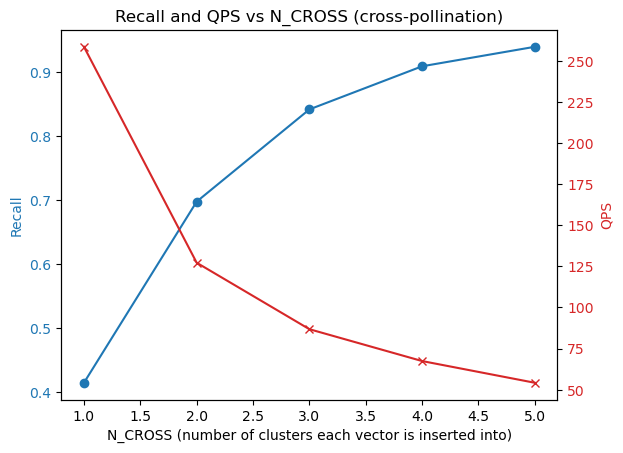

In [6]:
# Constants
DATA_URL = "http://ann-benchmarks.com/fashion-mnist-784-euclidean.hdf5"
CACHE = os.path.join(tempfile.gettempdir(), "fashion-mnist-784-euclidean.hdf5")
k = 10

# Download and load data
download_fashion_mnist(CACHE, DATA_URL)
xb, xq, gt = load_fashion_mnist(CACHE)
d = xb.shape[1]

# Build KMeans
inner_kmeans = build_kmeans(xb, d, 100)
_, xq_inner_assignments = inner_kmeans.index.search(xq, 1)
inner_centroids = inner_kmeans.centroids

outer_kmeans = build_kmeans(inner_centroids, d, 10)
_, inner_to_outer = outer_kmeans.index.search(inner_centroids, 1)
_, xq_outer_assignments = outer_kmeans.index.search(xq, 3)

# Evaluate cross-pollination
cross_range, recalls, qps_list = evaluate_cross_pollination(
    xb, xq, gt, inner_kmeans, inner_to_outer, xq_outer_assignments, k, d, N_PROBE=1, max_cross=5
)

# Plot results
plot_cross_pollination_results(cross_range, recalls, qps_list)

Clustering 50000 points in 784D to 400 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (3.63 s, search 3.40 s): objective=5.40624e+10 imbalance=1.222 nsplit=0       
Clustering 400 points in 784D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.03 s, search 0.01 s): objective=5.28421e+08 imbalance=1.278 nsplit=0       
Evaluating N_CROSS = 1
N_CROSS=1: recall=0.2553, qps=937.13
Evaluating N_CROSS = 2
N_CROSS=2: recall=0.4797, qps=482.54
Evaluating N_CROSS = 3
N_CROSS=3: recall=0.6325, qps=331.63
Evaluating N_CROSS = 4
N_CROSS=4: recall=0.7276, qps=255.02
Evaluating N_CROSS = 5
N_CROSS=5: recall=0.7937, qps=205.30
Evaluating N_CROSS = 6
N_CROSS=6: recall=0.8380, qps=167.77
Evaluating N_CROSS = 7
N_CROSS=7: recall=0.8725, qps=144.45
Evaluating N_CROSS = 8
N_CROSS=8: recall=0.8995, qps=126.10


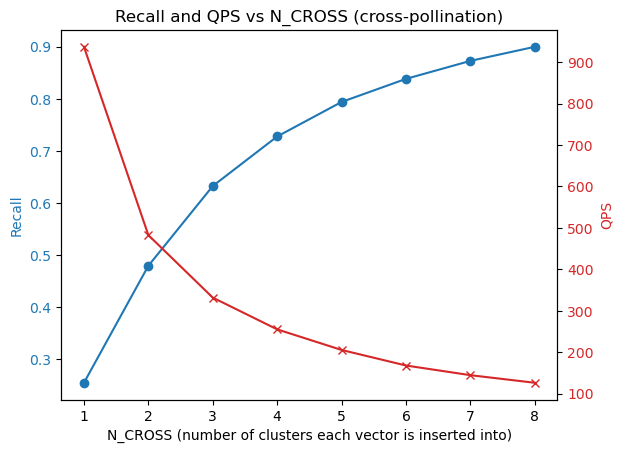

In [11]:
# Evaluate cross-pollination with 400 inner clusters

# Build KMeans with 400 inner clusters
inner_kmeans_400 = build_kmeans(xb, d, 400)
_, xq_inner_assignments_400 = inner_kmeans_400.index.search(xq, 1)
inner_centroids_400 = inner_kmeans_400.centroids

# Build outer KMeans on new inner centroids
outer_kmeans_400 = build_kmeans(inner_centroids_400, d, 10)
_, inner_to_outer_400 = outer_kmeans_400.index.search(inner_centroids_400, 1)
_, xq_outer_assignments_400 = outer_kmeans_400.index.search(xq, 3)

# Evaluate cross-pollination
cross_range_400, recalls_400, qps_list_400 = evaluate_cross_pollination(
    xb, xq, gt, inner_kmeans_400, inner_to_outer_400, xq_outer_assignments_400, k, d, N_PROBE=1, max_cross=8
)

# Plot results
plot_cross_pollination_results(cross_range_400, recalls_400, qps_list_400)

In [12]:
# Parameters for PQ
pq_m = 8      # Number of PQ sub-vectors (should divide d)
pq_nbits = 8  # Bits per sub-vector

# --- Build PQ codebooks and encode inner clusters ---
def build_pq_for_inner_clusters(xb, xb_inner_assignments, inner_centroids):
    pq_codebooks = {}
    pq_codes = {}
    for inner_id in range(inner_centroids.shape[0]):
        # Get all vectors assigned to this inner cluster
        idxs = np.where(xb_inner_assignments[:,0] == inner_id)[0]
        if len(idxs) == 0:
            continue
        # Compute residuals
        residuals = xb[idxs] - inner_centroids[inner_id]
        # Train PQ on residuals
        pq = faiss.ProductQuantizer(residuals.shape[1], pq_m, pq_nbits)
        pq.train(residuals)
        # Encode residuals
        codes = np.empty((len(residuals), pq.code_size), dtype='uint8')
        pq.compute_codes(residuals, codes)
        pq_codebooks[inner_id] = pq
        pq_codes[inner_id] = (idxs, codes)
    return pq_codebooks, pq_codes

In [13]:
# --- Search using PQ codes in inner clusters ---
def search_query_pq_inner(x, inner_kmeans, inner_centroids, pq_codebooks, pq_codes, xb, k):
    # Find closest inner cluster
    _, inner_assign = inner_kmeans.index.search(x.reshape(1, -1), 1)
    inner_id = int(inner_assign[0,0])
    if inner_id not in pq_codebooks:
        # fallback to brute-force
        dists = np.linalg.norm(xb - x.reshape(1, -1), axis=1)
        idx = np.argsort(dists)[:k]
        return idx, dists[idx]
    # Compute residual for query
    residual = x - inner_centroids[inner_id]
    pq = pq_codebooks[inner_id]
    idxs, codes = pq_codes[inner_id]
    # Compute distances from query residual to all PQ codes in this cluster
    dis = pq.compute_distance_table(residual.reshape(1, -1)).reshape(-1, pq.ksub * pq.M)
    # Use FAISS's search with PQ codes
    # For each code, sum the lookup table entries
    lookup = pq.compute_distance_table(residual.reshape(1, -1)).reshape(pq.M, pq.ksub)
    dists = np.zeros(len(codes), dtype='float32')
    for i, code in enumerate(codes):
        dists[i] = sum(lookup[m, code[m]] for m in range(pq.M))
    topk = np.argsort(dists)[:k]
    return idxs[topk], dists[topk]

In [15]:
# --- Product Quantization Example ---
# Assign each vector to its closest inner cluster
_, xb_inner_assignments = inner_kmeans.index.search(xb, 1)

# Build PQ codebooks and codes for each inner cluster
pq_codebooks, pq_codes = build_pq_for_inner_clusters(xb, xb_inner_assignments, inner_centroids)

# Search all queries using PQ in inner clusters
I = []
D = []
for x in xq:
    idxs, dists = search_query_pq_inner(x, inner_kmeans, inner_centroids, pq_codebooks, pq_codes, xb, k)
    I.append(idxs)
    D.append(dists)
I = np.array(I)
D = np.array(D)
recall = (I == gt[:, :k]).sum() / (gt.shape[0] * k)
print(f"Recall@{k} using PQ in inner clusters: {recall:.4f}")

RuntimeError: Error in void faiss::Clustering::train_encoded(idx_t, const uint8_t *, const Index *, Index &, const float *) at /Users/runner/miniconda3/conda-bld/faiss-pkg_1745590552381/work/faiss/Clustering.cpp:279: Error: 'nx >= k' failed: Number of training points (82) should be at least as large as number of clusters (256)